# Time series clustering

Explorando métodos y métricas de distancia para la agrupación de series de tiempo 

In [1]:
# import of libraries we will use
%matplotlib inline
import random
from math import sqrt, log, floor
from fastdtw import fastdtw
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import euclidean
import scipy.cluster.hierarchy
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics import mean_squared_error

sns.set(style='white')
# "fix" the randomness for reproducibility
random.seed(42)

Este conjunto de datos se compone de alrededor de 200 series temporales multidimensionales. Cada serie contiene medidas tomadas por 23 sensores.

In [3]:
# load data
data = pd.read_csv('data/train.txt', header=None, delim_whitespace=True)
# data normalization
for column in range(2, 26):
    data[column] = (data[column] - data[column].mean()) / data[column].std()
data.shape

(45918, 26)

## Data exploration
La duración media de la serie ronda los 210 pasos de tiempo. La longitud mínima es de 128 pasos de tiempo y el máximo es de 357 pasos de tiempo.

In [4]:
data[0].value_counts().describe()

count    218.000000
mean     210.633028
std       43.595578
min      128.000000
25%      177.000000
50%      209.500000
75%      236.000000
max      357.000000
Name: 0, dtype: float64

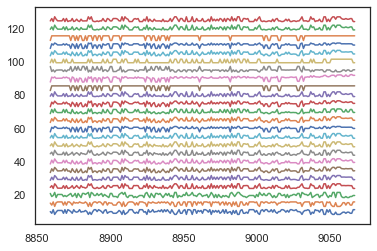

In [5]:
serie = data[data[0]==43]
for i in range(2, 26):
    (serie[i]+5*i).plot(x=1)

Vemos que muchos sensores miden cosas similares y hay mucho ruido.


Al principio, intentamos agrupar series de tiempo completas. Con el fin de evaluar los resultados de los diferentes algoritmos de agrupamiento, generamos un conjunto de entrenamiento con etiquetas de verdad del terreno cortando una cola de longitud aleatoria de cada serie temporal. La etiqueta de una serie es entonces la longitud de la cola cortada. Probamos los algoritmos de agrupamiento de K-means y HAC con distancia euclidiana y DTW. La evaluación que utiliza información mutua normalizada y un índice de rand ajustado ha mostrado un rendimiento deficiente. Atribuimos estos resultados a un ruido significativo en los datos y al hecho de que las series tienen longitudes muy diferentes. Esto ha llevado a nuestro segundo enfoque, agrupar solo fragmentos de series.

## Agrupando pedazos de series

La idea es cortar series en trozos separados de igual longitud y asignarles etiquetas en función de la distancia desde el final de la serie.

In [6]:
# group data by each timeserie
grouped = data.groupby(0)
series = [group.drop(labels=[0,1], axis=1) for name, group in grouped]
# number of clusters
k = 6
# length of chunks
chunk_length = 10
# go through groups and compute chunks and labels
train_set = []
true_labels = []
for serie in series:
    reversed_serie = serie.iloc[::-1]
    for i in range(len(serie) // chunk_length):        
        chunk = reversed_serie[i*10:(i+1)*10]
        true_label = i
        train_set.append(chunk)
        true_labels.append(true_label)


Algunos algoritmos son lentos, por lo que se podria muestrear solo un subconjunto de fragmentos para ejecutar 

In [7]:
# sampling
n = 100
indices = random.sample(list(range(len(train_set))), k=n) 
sample = [train_set[i] for i in indices]
sample_labels = [true_labels[i] for i in indices]

In [16]:
np.shape(sample_labels)

(100,)

In [18]:
np.shape(sample[1])

(10, 24)

### Distance computations

Calculando distancias entre trozos, se pueden evaluar métricas de distancia, distancia Euclidiana, RMS, DTW . Como los trozos son de la misma longitud, RMS es solo una versión escalada de la distancia euclédica que da como resultado grupos muy similares o idénticos. Los cálculos de la distancia Euclidiana y RMS son bastante rápidos, mientras que DTW se ejecuta un poco más lento y LCSS fue el más lento. Tomaría más de una hora calcular las distancias de cada par de trozos.

In [8]:
# compute eucledean distance
euclidean_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        euclidean_distances[i,j] = euclidean(sample[i].values.flatten(),
                                             sample[j].values.flatten())

In [9]:
# compute distances using RMSE
rmse_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        rmse_distances[i,j] = sqrt(mean_squared_error(sample[i].values.flatten(),
                                                      sample[j].values.flatten()))

In [10]:
#sns.heatmap(rmse_distances, xticklabels=False, yticklabels=False)

In [11]:
# compute distances using DTW
def dtw(x, y):
    dist, _ = fastdtw(x, y, dist=euclidean)
    return dist

dtw_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        dtw_distances[i,j] = dtw(sample[i], sample[j])

## Clustering algorithms

Para cada una de estas métricas, se prueban lo algoritmos de agrupación, K-medias y agrupación jerárquica.

In [20]:
k = 6
km = KMeans(n_clusters=k)
y_pred_km_euc=km.fit_predict(euclidean_distances)
y_pred_km_dtw = KMeans(n_clusters=k).fit_predict(dtw_distances)
y_pred_km_rmse = KMeans(n_clusters=k).fit_predict(rmse_distances)

D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
y_pred_hac_euc = AgglomerativeClustering(n_clusters=k)\
                 .fit_predict(euclidean_distances)
y_pred_hac_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(dtw_distances)
y_pred_hac_rmse = AgglomerativeClustering(n_clusters=k).fit_predict(rmse_distances)

## Evaluación

In [ ]:
# True label normalisation
log_base = max(true_labels)**(1 / k) + 0.05
normalised_true_labels = [floor(log(l+1, log_base)) for l in sample_labels]

In [ ]:
print('Normalized Mutual Information')
print('K-means + Eucledean: ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_km_euc))
print('K-means + RMS:       ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_km_rmse))
print('K-means + DTW:       ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_km_dtw))
print('HAC + Eucledean:     ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_hac_euc))
print('HAC + RMS:           ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_hac_rmse))
print('HAC + DTW:           ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_hac_dtw))

In [ ]:
print('Adjusted Rand Index')
print('K-means + Euclidean:  ', adjusted_rand_score(normalised_true_labels,
                                                    y_pred_km_euc))
print('K-means + RMS:       ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_km_rmse))
print('K-means + DTW:       ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_km_dtw))
print('HAC + Euclidean:     ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_hac_euc))
print('HAC + RMS:           ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_hac_rmse))
print('HAC + DTW:           ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_hac_dtw))

# Referencias 
https://github.com/effa/time-series-clustering